# Stitching thermal drone imagery

In [27]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/thermal-data/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
imgTimes = [1619811011923,1619811099149] # Specify times if wanted
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
distFilt = False
resolutions = [2, 6, 60]

In [28]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
#import cv2 as cv

In [29]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.npy'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

In [62]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['y'], merged['x'] = myProj(merged['longitude'].values, merged['latitude'].values)

In [63]:
merged

,imgPath,timestamp,latitude,longitude,altitude(m),pitch(deg),roll(deg),yaw(deg),y,x
51,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204650,0.108394,120.0,-11.4,3.7,-91.5,302416.998183,5.787742e+06
52,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204648,0.108318,120.1,0.4,4.8,-91.1,302411.797335,5.787742e+06
53,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204647,0.108254,120.0,-2.2,4.2,-91.2,302407.420709,5.787742e+06
54,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204646,0.108182,120.0,-2.1,5.2,-91.2,302402.497560,5.787742e+06
55,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204645,0.108109,120.0,-2.0,4.9,-91.1,302397.506096,5.787742e+06
...,...,...,...,...,...,...,...,...,...,...
134,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.205552,0.107345,119.9,-1.8,4.6,-91.1,302349.339967,5.787845e+06
135,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.205551,0.107271,119.9,-1.5,5.1,-91.2,302344.280290,5.787845e+06
136,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.205550,0.107197,120.0,-1.3,5.6,-91.1,302339.220612,5.787845e+06
137,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.205550,0.107115,120.0,-1.3,4.5,-91.1,302333.618863,5.787845e+06


## Velocity Correction Attempt

In [ ]:
# Coordinates from initial and speed
init = merged.iloc[0]
pi1 = pathDf.loc[pathDf['timestamp']==init['timestamp']].index[0]
meas = merged.iloc[1]
pi2 = pathDf.loc[pathDf['timestamp']==meas['timestamp']].index[0]
vels = pathDf.loc[pi1:pi2][['velocityX(mps)','velocityY(mps)']].mean()

In [ ]:
vels

In [ ]:
pathDf.loc[pathDf['timestamp']==init['timestamp']].index[0]

In [ ]:
init

## Orientation Correction

In [64]:
# Orientation correction
dist = merged['altitude(m)']*np.tan(np.deg2rad(merged['pitch(deg)']))
merged['xc'], merged['yc'] = merged.x+(dist*np.sin(np.deg2rad(merged['yaw(deg)']))), merged.y+(dist*np.cos(np.deg2rad(merged['yaw(deg)'])))
if distFilt: merged = merged[abs(dist) < distFilt]

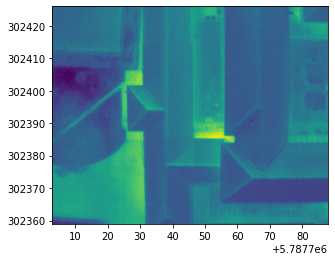

In [65]:
# Single image
val = 0.27
downsample = int(np.floor(val/pxSize))
imgExArr = np.load(merged.iloc[0]['imgPath'])
ds_array = imgExArr/255
rEx = block_reduce(ds_array, (downsample, downsample), np.mean)

# Get x,y coordinates for each pixel
yCoords, xCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq])
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

row = merged.iloc[5]
imgst = np.load(row.imgPath)[yq:3*yq,xq:3*xq]/255
total = np.concatenate((xmcr+row.xc, ymcr+row.yc,imgst.reshape(-1,1)),axis=-1)
extent = (np.ceil(min(total[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))
rs = np.dstack((total[:,2].reshape(2*yq,2*xq)))
plt.imshow(imgst,extent=extent)

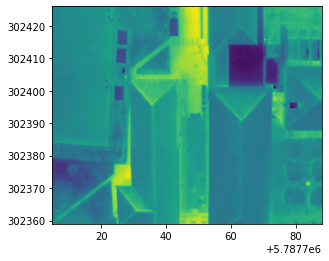

In [66]:
row = merged.iloc[10]
imgst = np.load(row.imgPath)[yq:3*yq,xq:3*xq]/255
total2 = np.concatenate((xmcr+row.xc, ymcr+row.yc,imgst.reshape(-1,1)),axis=-1)
extent = (np.ceil(min(total2[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))
rs = np.dstack((total[:,2].reshape(2*yq,2*xq)))
plt.imshow(imgst,extent=extent)

In [67]:
alltot = np.vstack((total, total2))
extot = (np.ceil(min(alltot[:,0])), np.floor(max(alltot[:,0])),np.ceil(min(alltot[:,1])),np.floor(max(alltot[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

xsGrid = np.arange(extot[0], extot[1], val)
ysGrid = np.arange(extot[2], extot[3], val)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

method = 'nearest'
r,g,b = [griddata(alltot[1:,:2], alltot[1:,i], (xsGridm, ysGridm), method=method) for i in [2,3,4]]

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,15])
#extent = (np.ceil(min(total[:,0])), np.floor(max(total[:,0])),np.ceil(min(total[:,1])),np.floor(max(total[:,1])))# minx, maxx, miny, maxy = min(total[:,0]), max(total[:,0]), min(total[:,1]), max(total[:,1])

plt.imshow(np.dstack((r, g, b)),extent=extot)

IndexError: index 3 is out of bounds for axis 1 with size 3

88it [00:03, 25.18it/s] 


Text(0.5, 1.0, 'Interpolation to grid using every 1 images')

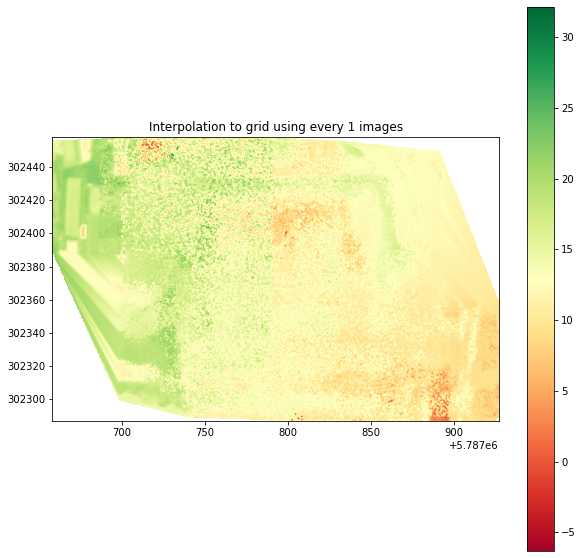

In [75]:
# Loop over resolution to create combined image for each
# Initial setup and downsampling if desired
val = 0.27
downsample = int(np.floor(val/pxSize))
imgExArr = np.load(merged.iloc[0]['imgPath'])
ds_array = imgExArr/255
rEx = block_reduce(ds_array, (downsample, downsample), np.mean)

# Get x,y coordinates for each pixel
yCoords, xCoords = [(np.array(range(rEx.shape[i]))-(rEx.shape[i]/2))*val+val/2 for i in [0,1]]
xq, yq = int(np.floor(len(xCoords)/4)), int(np.floor(len(yCoords)/4))
xmCoords, ymCoords = np.meshgrid(xCoords[xq:3*xq],yCoords[yq:3*yq])
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

# Loop over images
skip=1
alltot = [0,0,0]
for index, row in tqdm(merged[::skip].iterrows()):
    imgst = np.load(row.imgPath)[yq:3*yq,xq:3*xq]
    total = np.concatenate((xmcr+row.xc, ymcr+row.yc,imgst.reshape(-1,1)),axis=-1)
    alltot = np.vstack((alltot,total))

alltot = alltot[1:,:]
extot = (np.ceil(min(alltot[:,0])), np.floor(max(alltot[:,0])),np.ceil(min(alltot[:,1])),np.floor(max(alltot[:,1])))
xsGrid = np.arange(extot[0], extot[1], val)
ysGrid = np.arange(extot[2], extot[3], val)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

method = 'linear'
gridded = griddata(alltot[1:,:2], alltot[1:,2], (xsGridm, ysGridm), method=method)

# Plot 
fig, ax = plt.subplots(1,1,figsize=[10,10])

a = ax.imshow(gridded,extent=extot, cmap='RdYlGn')
fig.colorbar(a, ax=ax)
ax.set_title('Interpolation to grid using every '+str(skip)+' images')

(Text(0.5, 1.0, 'Full resolution'), Text(0.5, 1.0, '6 m resolution'))

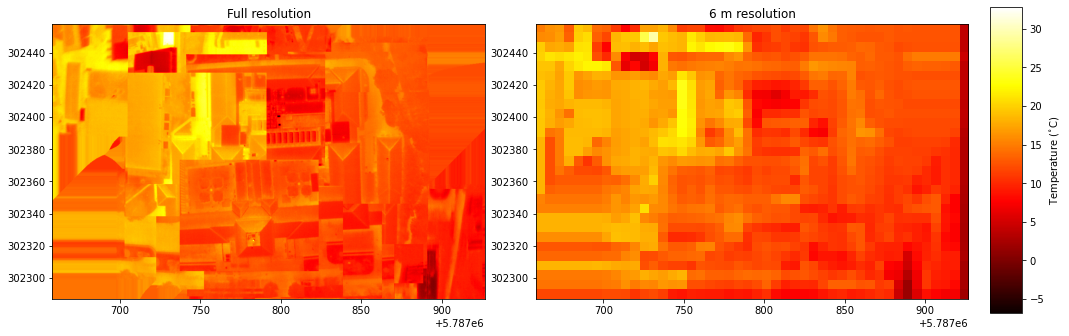

In [139]:
# val = 6
cmap='hot'
# method = 'nearest'
# gridded = griddata(alltot[1:,:2], alltot[1:,2], (xsGridm, ysGridm), method=method)
# downsample = int(np.floor(val/pxSize))
# ds = block_reduce(gridded, (downsample, downsample), np.mean)

# Plot 
fig, axs = plt.subplots(1,2,figsize=[15,5])

a = axs[0].imshow(gridded,extent=extot, cmap=cmap)
b = axs[1].imshow(ds,extent=extot, cmap=cmap, vmin=gridded.min(),vmax=gridded.max())
plt.tight_layout(h_pad=1)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.03, 0.85])
c = fig.colorbar(a, cax=cbar_ax)
c.set_label('Temperature ($^{\circ}$C)')

axs[0].set_title('Full resolution'), axs[1].set_title(str(val)+' m resolution')

In [140]:
fig.savefig('plots/thermal_rollcorr.png')

In [ ]:
# Plot example downsampled image
for i, val in enumerate(resolutions):
    downsample = int(np.floor(val/pxSize))
    # first, change to 0-1
    ds_array = imgExArr/255
    r = block_reduce(ds_array[:, :, 0], (downsample, downsample), np.mean)
    g = block_reduce(ds_array[:, :, 1], (downsample, downsample), np.mean)
    b = block_reduce(ds_array[:, :, 2], (downsample, downsample), np.mean)
    ds_array = np.stack((r, g, b), axis=-1)
    if i<2:
        c = axs[1,i].imshow(ds_array)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
plt.show()